In [1]:
import torch
import segmentation_models_pytorch as smp
from collections import OrderedDict

# Charger le state_dict
state_dict = torch.load("unetplusplus_model.pth", map_location=torch.device("cpu"))

# Supprimer le préfixe "module." si le modèle venait de DataParallel
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "") if k.startswith("module.") else k
    new_state_dict[name] = v

# Recréer le modèle avec les mêmes paramètres
modelUnetPlusPlus = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",  # ou None si tu préfères éviter les conflits
    in_channels=3,
    classes=1
)

# Charger les poids corrigés
modelUnetPlusPlus.load_state_dict(new_state_dict)
modelUnetPlusPlus.eval()

print("✅ Modèle UnetPlusPlus chargé avec succès.")

✅ Modèle UnetPlusPlus chargé avec succès.


In [2]:
# Charger le state_dict
state_dict = torch.load("deeplabv3_model.pth", map_location=torch.device("cpu"))

# Supprimer le préfixe "module." si le modèle venait de DataParallel
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "") if k.startswith("module.") else k
    new_state_dict[name] = v

# Recréer le modèle avec les mêmes paramètres
modelUnetDeepLab = smp.DeepLabV3(
    encoder_name="resnet34",
    encoder_weights="imagenet",  # ou None si tu préfères éviter les conflits
    in_channels=3,
    classes=1
)

# Charger les poids corrigés
modelUnetDeepLab.load_state_dict(new_state_dict)
modelUnetDeepLab.eval()

print("✅ Modèle DeepLap chargé avec succès.")

✅ Modèle DeepLap chargé avec succès.


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

def predict_and_show(model, image_path, mask_path, image_size=(512, 512), device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 📥 Charger image et masque avec PIL
    image = Image.open(image_path).convert("L")  # niveaux de gris
    mask = Image.open(mask_path).convert("L")    # niveaux de gris

    # 🧼 Redimensionner
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    # 🧠 Convertir image en 3 canaux
    image_np = np.stack([np.array(image)] * 3, axis=-1)
    mask_np = np.array(mask)

    # 🧪 Prétraitement avec Albumentations
    transform = A.Compose([
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])
    augmented = transform(image=image_np, mask=mask_np)
    input_tensor = augmented["image"].unsqueeze(0).to(device)

    # 🔮 Prédiction
    model.eval()
    with torch.no_grad():
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255

    # ➕ Superposer le contour du masque prédit sur l'image originale
    image_with_contour = np.array(image.convert("RGB"))  # Convertir en RGB pour couleur
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image_with_contour, contours, -1, (255, 0, 0), thickness=2)  # Rouge

    # 📊 Affichage
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image_with_contour)
    plt.title("Image + Contour préd")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Masque réel")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Masque prédit")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

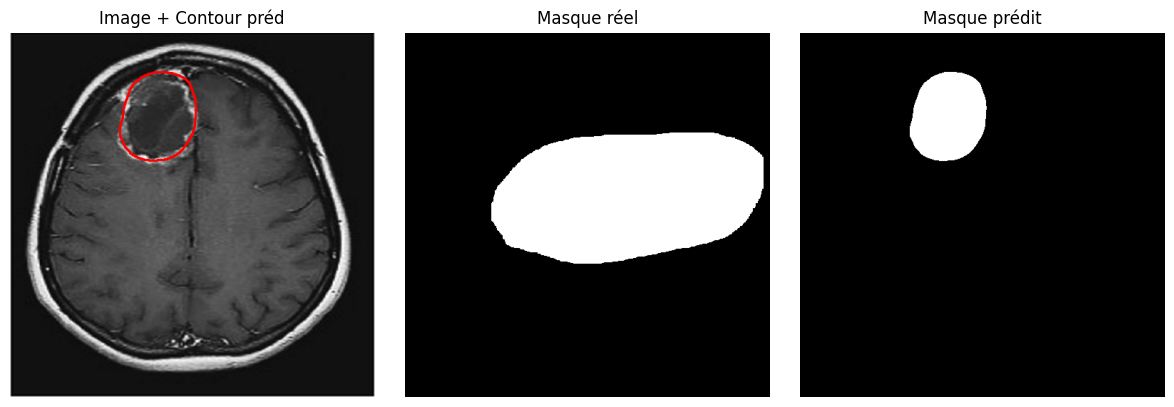

In [4]:
predict_and_show(
        model=modelUnetDeepLab,
        image_path=r"C:\Users\HP\Desktop\app va\534027_1_En_46_Fig4_HTML.png",
        mask_path=r"C:\Users\HP\Desktop\cours_WISD_S2\Recherche opérationnelle & Oprimisation\Project\data\test\masks\benign (62)_mask.png",
        image_size=(512, 512)
    )

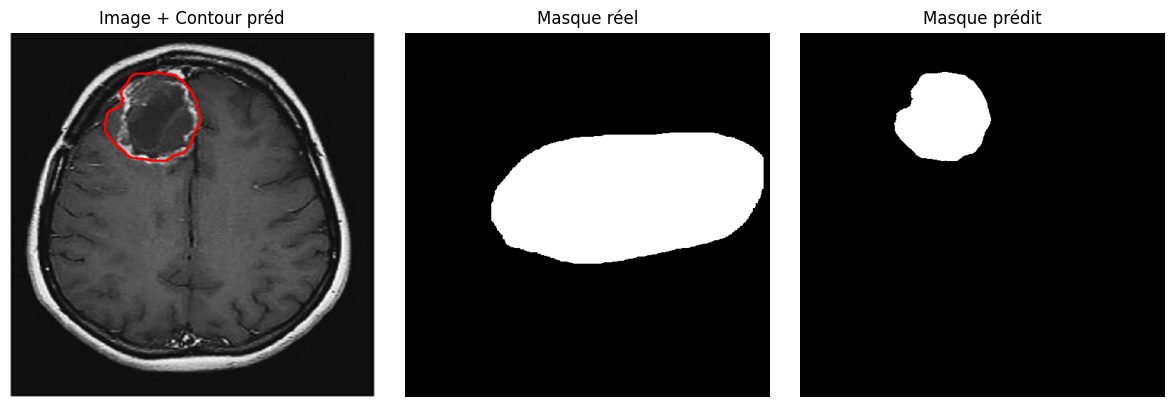

In [5]:
predict_and_show(
        model=modelUnetPlusPlus,
        image_path=r"C:\Users\HP\Desktop\app va\534027_1_En_46_Fig4_HTML.png",
        mask_path=r"C:\Users\HP\Desktop\cours_WISD_S2\Recherche opérationnelle & Oprimisation\Project\data\test\masks\benign (62)_mask.png",
        image_size=(512, 512)
    )

In [6]:
import numpy as np
import torch
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

def predict(model, image_np, image_size=(512, 512), device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 📏 Redimensionner l'image
    image_resized = cv2.resize(image_np, image_size)

    # 📷 Convertir en 3 canaux si image en niveaux de gris
    if len(image_resized.shape) == 2:  # (H, W)
        image_resized = np.stack([image_resized] * 3, axis=-1)
    elif image_resized.shape[2] == 1:  # (H, W, 1)
        image_resized = np.concatenate([image_resized] * 3, axis=-1)

    # 🔄 Prétraitement (normalisation et conversion tensor)
    transform = A.Compose([
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])
    augmented = transform(image=image_resized)
    input_tensor = augmented["image"].unsqueeze(0).to(device)

    # 🔮 Prédiction
    model.eval()
    with torch.no_grad():
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255

    # 🧠 Extraire les contours
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 🖼️ Tracer les contours sur une copie de l'image originale (redimensionnée en RGB)
    image_with_contour = cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR)  # OpenCV utilise BGR
    cv2.drawContours(image_with_contour, contours, -1, (0, 0, 255), thickness=2)  # Rouge en BGR

    # Retourner l'image avec contours (toujours en BGR)
    return image_with_contour




In [7]:
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import StreamingResponse
from fastapi.middleware.cors import CORSMiddleware

from PIL import Image
import numpy as np
import io
import cv2
import nest_asyncio
import uvicorn
import threading

nest_asyncio.apply()

app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # à adapter selon besoin
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

BOUNDARY = "simpleboundary1234567890"

def build_multipart(files, boundary):
    """Construit une réponse multipart/form-data à partir de buffers."""
    lines = []
    for fieldname, filename, filebytes, mimetype in files:
        lines.append(f"--{boundary}")
        lines.append(f'Content-Disposition: form-data; name="{fieldname}"; filename="{filename}"')
        lines.append(f"Content-Type: {mimetype}")
        lines.append("")  # empty line before file content
        lines.append(filebytes)
    lines.append(f"--{boundary}--")
    lines.append("")
    # Joindre en bytes
    body = b""
    for part in lines:
        if isinstance(part, str):
            body += part.encode() + b"\r\n"
        else:
            body += part + b"\r\n"
    return body

@app.post("/overlay-contours/")
async def overlay_contours(
    image_file: UploadFile = File(...)
):
    image = Image.open(io.BytesIO(await image_file.read())).convert("L")
    image = image.resize((512, 512))
    image_np = np.stack([np.array(image)] * 3, axis=-1).astype(np.uint8)

    result1 = predict(modelUnetPlusPlus, image_np.copy())
    result2 = predict(modelUnetDeepLab, image_np.copy())
    # Pour test, remplacer par image_np :
    # result1 = image_np
    # result2 = image_np

    result_image1 = Image.fromarray(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    result_image2 = Image.fromarray(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    
    buffer1 = io.BytesIO()
    buffer2 = io.BytesIO()
    result_image1.save(buffer1, format="PNG")
    result_image2.save(buffer2, format="PNG")
    buffer1.seek(0)
    buffer2.seek(0)
    files = [
        ("file1", "result1.png", buffer1.getvalue(), "image/png"),
        ("file2", "result2.png", buffer2.getvalue(), "image/png")
    ]
    multipart_body = build_multipart(files, BOUNDARY)
    headers = {
        "Content-Type": f"multipart/form-data; boundary={BOUNDARY}",
        "Content-Length": str(len(multipart_body)),
    }
    return StreamingResponse(io.BytesIO(multipart_body), headers=headers)

def run_server():
    uvicorn.run(app, host="127.0.0.1", port=8000)

thread = threading.Thread(target=run_server)
thread.start()


INFO:     Started server process [16568]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:53871 - "POST /overlay-contours/ HTTP/1.1" 200 OK
